## **SKENARIO 1: Klasifikasi KNN - Dimensional Reduction**

## **IMPORT LIBRARY**

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
import time

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

## **DATA LOADING**

In [61]:
# Load dan read data
url_train = "https://drive.google.com/uc?export=download&id=1mwBc1Xbdp5vezgcQLi-BWcsaVNxiqblv"
url_test = "https://drive.google.com/uc?export=download&id=1nSQr83pGwZQ-ShLgrDWH0AoPEi3E5FgF"
url_label = "https://drive.google.com/uc?export=download&id=169-NXQYAKyntsfhcEjzWc0oNB4dD4DkQ"

df_train = pd.read_csv(url_train)
df_test = pd.read_csv(url_test)
df_label = pd.read_csv(url_label)

In [62]:
# Menggabungkan fitur train dan label 
df = pd.concat([df_train, df_label], axis=1)
print(f"Dataset Loaded\nDimensi: {df.shape}")

Dataset Loaded
Dimensi: (3817, 17)


## **PREPROCESSING**

### - **Feature Engineering**

In [63]:
def feature_engineering(df_in):
    REF_YEAR = 2025
    REF_DATE = datetime(2025, 12, 31)

    df_out = df_in.copy()
    
    # 1. Fix Date Type
    df_out['tanggal_menjadi_anggota'] = pd.to_datetime(df_out['tanggal_menjadi_anggota'], errors='coerce')
    
    # 2. Feature: Umur
    df_out['umur'] = REF_YEAR - df_out['tahun_kelahiran']
    
    # 3. Feature: Lama Bergabung (Hari)
    df_out['lama_bergabung_hari'] = (REF_DATE - df_out['tanggal_menjadi_anggota']).dt.days
    
    # 4. Feature: Total Belanja
    col_belanja = ['belanja_buah', 'belanja_daging', 'belanja_ikan', 'belanja_kue']
    df_out[col_belanja] = df_out[col_belanja].fillna(0)
    df_out['total_belanja'] = df_out[col_belanja].sum(axis=1)

    # 5. Rata-rata belanja per kategori
    df_out['avg_belanja'] = df_out['total_belanja'] / 4

    # 6. Rasio belanja protein
    df_out['rasio_protein'] = (
        df_out['belanja_daging'] + df_out['belanja_ikan']
    ) / (df_out['total_belanja'] + 1)
    
    # Drop kolom mentah
    df_out.drop(columns=['tahun_kelahiran', 'tanggal_menjadi_anggota'], inplace=True, errors='ignore')
    
    return df_out

df_eng = feature_engineering(df)
print(f"Feature Engineering Selesai\nDimensi: {df_eng.shape}")

Feature Engineering Selesai
Dimensi: (3817, 20)


### - **Data Cleaning**

In [64]:
# Ganti noise '5' dengan NaN agar dianggap missing value
df_clean = df_eng.copy()

cols_with_noise = ['pendidikan', 'status_pernikahan']
for col in cols_with_noise:
    df_clean[col] = df_clean[col].replace('5', np.nan)

In [65]:
# Memisahkan Fitur (X) dan Target (y)
target_col = 'jumlah_promosi'
X = df_clean.drop(columns=[target_col])
y = df_clean[target_col]

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [66]:
# Melakukan Split data
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data Split Done. \nTrain Shape: {X_train_raw.shape}, Val Shape: {X_val_raw.shape}")

Data Split Done. 
Train Shape: (3053, 19), Val Shape: (764, 19)


In [67]:
X_train_clean = X_train_raw.copy()
X_val_clean = X_val_raw.copy()

In [68]:
# Imputasi Missing Values

# Numeric (Median)
imputer_num = SimpleImputer(strategy='median')
X_train_clean[num_cols] = imputer_num.fit_transform(X_train_clean[num_cols])
X_val_clean[num_cols] = imputer_num.transform(X_val_clean[num_cols])

# Categorical (Mode)
imputer_cat = SimpleImputer(strategy='most_frequent')
X_train_clean[cat_cols] = imputer_cat.fit_transform(X_train_clean[cat_cols])
X_val_clean[cat_cols] = imputer_cat.transform(X_val_clean[cat_cols])


X_train_imp = pd.DataFrame(X_train_clean, columns=X_train_clean.columns, index=X_train_raw.index)
X_val_imp = pd.DataFrame(X_val_clean, columns=X_val_clean.columns, index=X_val_raw.index)

print("Missing Value Imputation Selesai")

Missing Value Imputation Selesai


In [69]:
X_train_imp.isna().sum()

pendidikan             0
status_pernikahan      0
pendapatan             0
jumlah_anak_balita     0
jumlah_anak_remaja     0
terakhir_belanja       0
belanja_buah           0
belanja_daging         0
belanja_ikan           0
belanja_kue            0
pembelian_diskon       0
pembelian_web          0
pembelian_toko         0
keluhan                0
umur                   0
lama_bergabung_hari    0
total_belanja          0
avg_belanja            0
rasio_protein          0
dtype: int64

In [70]:
X_val_imp.isna().sum()

pendidikan             0
status_pernikahan      0
pendapatan             0
jumlah_anak_balita     0
jumlah_anak_remaja     0
terakhir_belanja       0
belanja_buah           0
belanja_daging         0
belanja_ikan           0
belanja_kue            0
pembelian_diskon       0
pembelian_web          0
pembelian_toko         0
keluhan                0
umur                   0
lama_bergabung_hari    0
total_belanja          0
avg_belanja            0
rasio_protein          0
dtype: int64

### - **FEATURE TRANSFORMATION**

In [71]:
# Melakukan encoding
X_train_enc = X_train_imp.copy()
X_val_enc = X_val_imp.copy()

# Ordinal Mapping (Pendidikan)
education_map = {'SMP': 1, 'SMA': 2, 'Sarjana': 3, 'Magister': 4, 'Doktor': 5}
X_train_enc['pendidikan'] = X_train_enc['pendidikan'].map(education_map)
X_val_enc['pendidikan'] = X_val_enc['pendidikan'].map(education_map)

# One-Hot Encoding (Status Pernikahan)
X_train_enc = pd.get_dummies(X_train_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = pd.get_dummies(X_val_enc, columns=['status_pernikahan'], prefix='status', dtype=int)
X_val_enc = X_val_enc.reindex(columns=X_train_enc.columns, fill_value=0)

print("Encoding selesai")

Encoding selesai


In [72]:
# Handling Outliers 
X_train_out = X_train_enc.copy()
X_val_out = X_val_enc.copy()

def get_iqr_bounds(series, factor):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR

    return lower_bound, upper_bound


outlier_summary = []

num_cols = X_train_out.select_dtypes(include="number").columns.tolist()

for col in num_cols:
    mild_l, mild_u = get_iqr_bounds(X_train_out[col], 1.5)
    ext_l, ext_u = get_iqr_bounds(X_train_out[col], 3)
    vext_l, vext_u = get_iqr_bounds(X_train_out[col], 5)

    outlier_summary.append({
        "feature": col,
        "mild_outlier_pct (%)":
            ((X_train_out[col] < mild_l) | (X_train_out[col] > mild_u)).mean() * 100,
        "extreme_outlier_pct (%)":
            ((X_train_out[col] < ext_l) | (X_train_out[col] > ext_u)).mean() * 100,
        "very_extreme_outlier_pct (%)":
            ((X_train_out[col] < vext_l) | (X_train_out[col] > vext_u)).mean() * 100
    })

outlier_df = pd.DataFrame(outlier_summary)
outlier_df

,feature,mild_outlier_pct (%),extreme_outlier_pct (%),very_extreme_outlier_pct (%)
0,pendidikan,2.325581,0.000000,0.000000
1,pendapatan,0.196528,0.000000,0.000000
2,jumlah_anak_balita,0.000000,0.000000,0.000000
3,jumlah_anak_remaja,0.000000,0.000000,0.000000
4,terakhir_belanja,0.000000,0.000000,0.000000
5,belanja_buah,7.402555,1.113659,0.000000
6,belanja_daging,4.192597,0.360301,0.000000
7,belanja_ikan,6.583688,0.425811,0.000000
8,belanja_kue,8.385195,1.244677,0.032755
9,pembelian_diskon,3.897805,0.458565,0.098264


In [73]:
cols_to_winsor = outlier_df.loc[
    outlier_df["mild_outlier_pct (%)"] > 1,
    "feature"
].tolist()

winsor_limits = {}

for col in cols_to_winsor:
    lower, upper = get_iqr_bounds(X_train_out[col], factor=1.5)
    winsor_limits[col] = (lower, upper)

for col, (lower, upper) in winsor_limits.items():
    X_train_out[col] = X_train_out[col].clip(lower, upper)
    X_val_out[col] = X_val_out[col].clip(lower, upper)

print("Handling outliers selesai")

Handling outliers selesai


In [74]:
# Melakukan Scaling
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_out),
    columns=X_train_out.columns,
    index=X_train_out.index
)

X_val_scaled = pd.DataFrame(
    scaler.transform(X_val_out),
    columns=X_val_out.columns,
    index=X_val_out.index
)

print("Scaling selesai")

Scaling selesai


In [75]:
X_train_scaled.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,umur,lama_bergabung_hari,total_belanja,avg_belanja,rasio_protein,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
700,0.0,-0.059931,0.0,1.0,0.395349,0.119889,0.053880,-0.121824,-0.288280,1.5,0.00,0.4,0.0,0.647059,0.0,-0.035931,-0.035931,0.371332,0.0,0.0,0.0,1.0,0.0
2044,0.0,0.000000,0.0,0.0,-0.813953,-0.049365,-0.303887,-0.269279,0.004037,0.0,-0.25,-0.6,0.0,-0.647059,0.0,-0.279728,-0.279728,-2.111294,0.0,0.0,0.0,1.0,0.0
644,2.0,0.845660,0.0,0.0,-0.465116,1.002973,1.531412,1.050619,2.110431,0.0,0.00,1.0,0.0,0.941176,0.0,1.354978,1.354978,0.026954,0.0,0.0,0.0,0.0,0.0
3218,0.0,-0.194915,0.0,2.0,0.372093,2.276619,0.569333,1.109597,2.253822,0.5,1.25,1.4,0.0,-0.176471,0.0,0.860978,0.860978,-1.013320,0.0,0.0,1.0,0.0,0.0
3393,0.0,0.565823,0.0,0.0,-0.883721,1.535780,0.236781,0.974424,0.400573,0.0,1.50,-0.2,0.0,0.470588,0.0,0.387935,0.387935,-0.549663,0.0,0.0,0.0,0.0,1.0


In [76]:
X_val_scaled.head()

,pendidikan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,umur,lama_bergabung_hari,total_belanja,avg_belanja,rasio_protein,status_Cerai,status_Cerai Mati,status_Menikah,status_Rencana Menikah,status_Sendiri
2561,0.0,0.035550,0.0,1.0,0.325581,-0.220569,-0.061735,-0.242340,0.164422,-0.5,0.50,1.0,0.0,0.941176,0.0,-0.116517,-0.116517,-0.117015,0.0,0.0,0.0,1.0,0.0
1425,0.0,0.570072,0.0,0.0,-0.720930,2.276619,0.762130,0.731540,0.982068,-1.0,1.50,-0.2,0.0,0.117647,0.0,0.865555,0.865555,-0.647270,0.0,0.0,1.0,0.0,0.0
2185,0.0,-1.143808,0.0,0.0,-1.069767,-0.103828,-0.286680,-0.124650,-0.271442,-0.5,-1.00,-0.8,0.0,-1.176471,0.0,-0.278690,-0.278690,-0.698257,0.0,0.0,0.0,0.0,1.0
2519,0.0,-0.548137,1.0,0.0,0.930233,-0.143374,-0.241610,-0.101679,-0.316135,-0.5,0.25,-0.4,0.0,-0.294118,0.0,-0.253056,-0.253056,0.225926,0.0,0.0,0.0,0.0,1.0
3045,0.0,0.531087,0.0,0.0,1.000000,1.937587,1.101438,0.699243,2.253822,-0.5,1.25,0.4,0.0,-0.941176,0.0,1.119365,1.119365,-0.479235,0.0,0.0,1.0,0.0,0.0


### - **FEATURE SELECTION**

In [77]:
pca = PCA(n_components=2, whiten=False, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

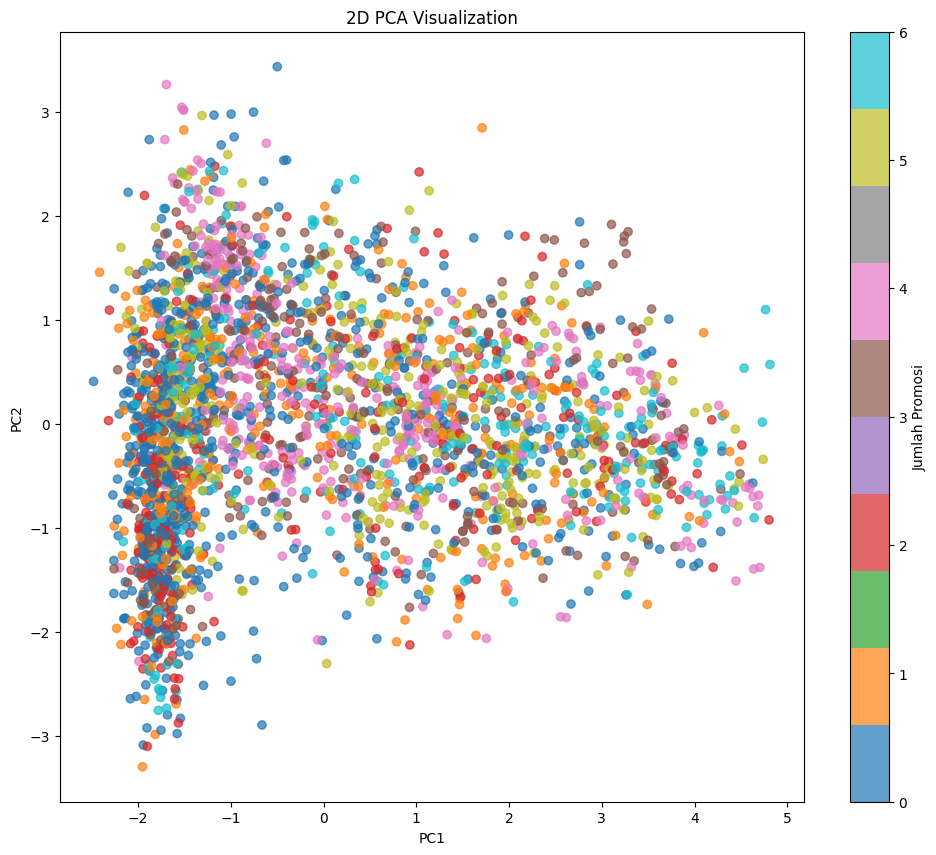

In [78]:
plt.figure(figsize=(12, 10))

sc = plt.scatter(
    X_train_pca[:, 0],
    X_train_pca[:, 1],
    c=y_train,
    cmap='tab10',
    alpha=0.7
)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2D PCA Visualization')

plt.colorbar(sc, label='Jumlah Promosi')
plt.show()

In [79]:
pca_cols = [f"PCA_{i+1}" for i in range(X_train_pca.shape[1])]

X_train_final = pd.DataFrame(
    X_train_pca,
    columns=pca_cols,
    index=X_train_scaled.index
)

X_val_final = pd.DataFrame(
    X_val_pca,
    columns=pca_cols,
    index=X_val_scaled.index
)

# Menampilkan explained variance ratio
explained_var = pca.explained_variance_ratio_
cum_explained_var = explained_var.cumsum()

for i, (var, cum_var) in enumerate(zip(explained_var, cum_explained_var), start=1):
    print(f"PC{i}: {var:.4f} | Cumulative: {cum_var:.4f}")

PC1: 0.3609 | Cumulative: 0.3609
PC2: 0.1197 | Cumulative: 0.4807


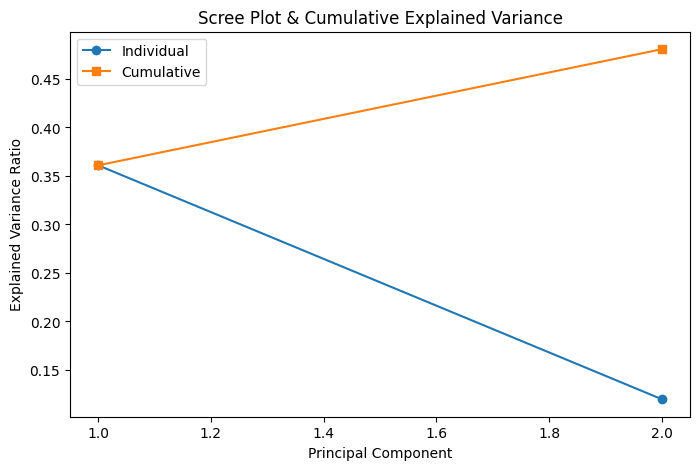

In [80]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_var) + 1), explained_var, marker='o')
plt.plot(range(1, len(cum_explained_var) + 1), cum_explained_var, marker='s')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot & Cumulative Explained Variance')
plt.legend(['Individual', 'Cumulative'])
plt.show()

In [81]:
X_train_final.head()

,PCA_1,PCA_2
700,-1.049594,1.223980
2044,-1.478036,-1.430130
644,2.864619,1.276039
3218,2.206919,-0.037536
3393,0.939426,-0.064147


In [82]:
X_val_final.head()

,PCA_1,PCA_2
2561,-0.641487,0.460275
1425,2.026311,-0.651961
2185,-1.869181,-1.615082
2519,-1.479697,-0.368094
3045,2.677361,-0.717034


## **MANUAL CALCULATION**

In [83]:
# train_sample = X_train_final.iloc[:5]
# val_sample = X_val_final.iloc[:1]

In [84]:
# dists = []
# for i in range(len(train_sample)):
#     # Euclidean Distance
#     d = np.linalg.norm(train_sample.iloc[i] - val_sample.iloc[0])
#     dists.append(d)

In [85]:
# # untuk k=3
# manual_res = pd.DataFrame({
#     'Train_Idx': train_sample.index, 
#     'Dist': dists, 
#     'Label': y_train.iloc[:5].values
# }).sort_values('Dist')
# manual_res.head(3)

## **MODELING**


Mencari nilai K terbaik (Accuracy & Macro F1)...
K= 1 | Accuracy=25.79% | Macro F1=22.62%
K= 2 | Accuracy=25.79% | Macro F1=22.62%
K= 3 | Accuracy=25.52% | Macro F1=22.37%
K= 4 | Accuracy=26.18% | Macro F1=23.25%
K= 5 | Accuracy=25.79% | Macro F1=23.07%
K= 6 | Accuracy=25.00% | Macro F1=21.77%
K= 7 | Accuracy=26.44% | Macro F1=23.04%
K= 8 | Accuracy=27.23% | Macro F1=23.56%
K= 9 | Accuracy=26.83% | Macro F1=23.29%
K=10 | Accuracy=26.96% | Macro F1=23.19%
K=11 | Accuracy=26.96% | Macro F1=23.11%
K=12 | Accuracy=27.88% | Macro F1=23.74%
K=13 | Accuracy=28.01% | Macro F1=24.11%
K=14 | Accuracy=27.88% | Macro F1=23.74%
K=15 | Accuracy=28.80% | Macro F1=24.28%
K=16 | Accuracy=28.40% | Macro F1=23.72%
K=17 | Accuracy=29.19% | Macro F1=24.09%
K=18 | Accuracy=29.32% | Macro F1=24.16%
K=19 | Accuracy=29.45% | Macro F1=24.29%
K=20 | Accuracy=29.45% | Macro F1=24.01%

===== BEST PARAMETER (BERDASARKAN MACRO F1) =====
Best K        : 19
Metric        : euclidean
Weights       : distance
Macro F1 

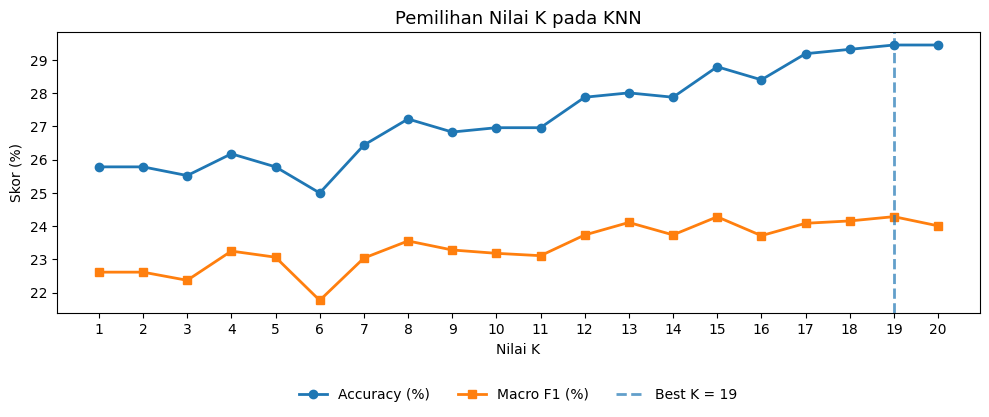

In [86]:
# Mencari Best K (Accuracy & Macro F1)
best_f1 = 0
best_k = 1
best_metric = None
best_weights = None

accuracies = []
f1_macros = []

print("\nMencari nilai K terbaik (Accuracy & Macro F1)...")

for k in range(1, 21):
    knn = KNeighborsClassifier(
        n_neighbors=k,
        weights='distance',
        metric='euclidean'
    )
    knn.fit(X_train_final, y_train)

    y_pred = knn.predict(X_val_final)

    acc = accuracy_score(y_val, y_pred)
    f1_macro = f1_score(y_val, y_pred, average='macro')

    accuracies.append(acc * 100)
    f1_macros.append(f1_macro * 100)

    print(f"K={k:2d} | Accuracy={acc*100:.2f}% | Macro F1={f1_macro*100:.2f}%")

    # Best berdasarkan Macro F1
    if f1_macro > best_f1:
        best_f1 = f1_macro
        best_k = k
        best_metric = knn.metric
        best_weights = knn.weights

print("\n===== BEST PARAMETER (BERDASARKAN MACRO F1) =====")
print(f"Best K        : {best_k}")
print(f"Metric        : {best_metric}")
print(f"Weights       : {best_weights}")
print(f"Macro F1      : {best_f1*100:.2f}%")

#===============================
# Visualisasi Accuracy & Macro F1
# ===============================
plt.figure(figsize=(10, 5))

ks = range(1, 21)

plt.plot(
    ks,
    accuracies,
    marker='o',
    linewidth=2,
    label='Accuracy (%)'
)

plt.plot(
    ks,
    f1_macros,
    marker='s',
    linewidth=2,
    label='Macro F1 (%)'
)

# ===============================
# TANDA K OPTIMAL
# ===============================
optimal_k = best_k  # = 19

# Garis vertikal
plt.axvline(
    x=optimal_k,
    linestyle='--',
    linewidth=2,
    alpha=0.7,
    label=f'Best K = {optimal_k}'
)

# ===============================
# Properti Plot
# ===============================
plt.title('Pemilihan Nilai K pada KNN', fontsize=13)
plt.xlabel('Nilai K')
plt.ylabel('Skor (%)')
plt.xticks(ks)

# Legend di bawah (konsisten VBNN)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.22),
    ncol=3,
    frameon=False
)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()


In [87]:
# Training
start_train = time.time()

knn_final = KNeighborsClassifier(
    n_neighbors=best_k,
    weights=best_weights,
    metric=best_metric
)
knn_final.fit(X_train_final, y_train)

train_time = time.time() - start_train
y_train_pred = knn_final.predict(X_train_final)

train_acc = accuracy_score(y_train, y_train_pred)
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')

print("===== TRAINING PERFORMANCE =====")
print(f"Training Time: {train_time:.2f} detik")
print(f"Training Accuracy: {train_acc * 100:.2f}%")
print(f"Training Macro F1: {train_f1_macro * 100:.2f}%")

===== TRAINING PERFORMANCE =====
Training Time: 0.00 detik
Training Accuracy: 100.00%
Training Macro F1: 100.00%


## **EVALUATION**

In [88]:
start_pred = time.time()
y_pred = knn_final.predict(X_val_final)
pred_time = time.time() - start_pred


val_acc = accuracy_score(y_val, y_pred)
val_f1_macro = f1_score(y_val, y_pred, average='macro')

print("===== EVALUATION PERFORMANCE (VALIDATION SET) =====")
print(f"Accuracy        : {val_acc * 100:.2f}%")
print(f"Macro F1 Score  : {val_f1_macro * 100:.2f}%")
print(f"Waktu Prediksi  : {pred_time:.6f} detik")

===== EVALUATION PERFORMANCE (VALIDATION SET) =====
Accuracy        : 29.45%
Macro F1 Score  : 24.29%
Waktu Prediksi  : 0.008000 detik



Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.50      0.41       195
           1       0.22      0.11      0.14       120
           2       0.19      0.09      0.12        79
           3       0.15      0.12      0.13        84
           4       0.35      0.54      0.43        91
           5       0.30      0.32      0.31       120
           6       0.19      0.13      0.16        75

    accuracy                           0.29       764
   macro avg       0.25      0.26      0.24       764
weighted avg       0.27      0.29      0.27       764



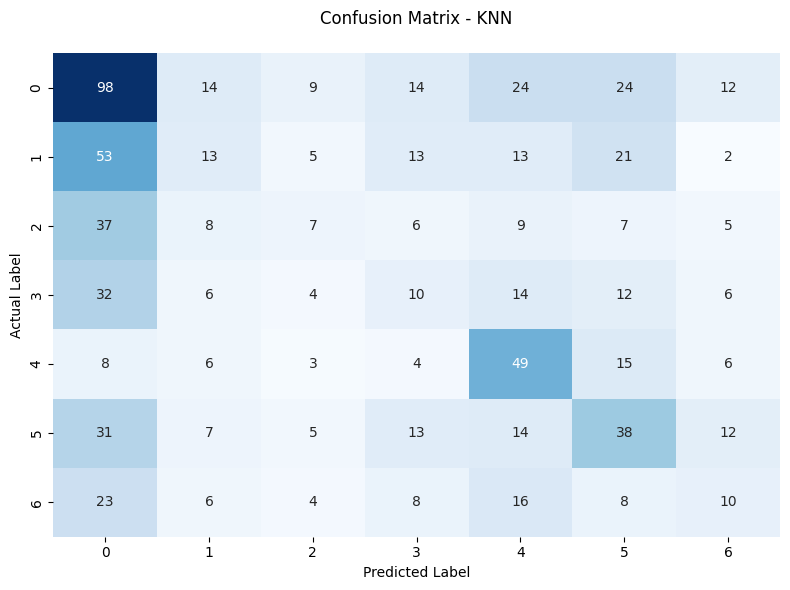

In [89]:
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False
)

plt.title(
    f'Confusion Matrix - KNN\n',
    fontsize=12
)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()

In [90]:
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

f1_scores = []
acc_scores = []
pred_times = []

print("\n===== 5-FOLD CROSS VALIDATION =====")

for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_final, y_train), 1):
    X_tr = X_train_final.values[train_idx]
    X_va = X_train_final.values[val_idx]
    y_tr = y_train.values[train_idx]
    y_va = y_train.values[val_idx]

    model_cv = KNeighborsClassifier(
        n_neighbors=best_k,
        weights=best_weights,
        metric=best_metric
    )
    model_cv.fit(X_tr, y_tr)

    start = time.time()
    y_pred_cv = model_cv.predict(X_va)
    pred_times.append(time.time() - start)

    acc_cv = accuracy_score(y_va, y_pred_cv)
    f1_cv = f1_score(y_va, y_pred_cv, average="macro")

    acc_scores.append(acc_cv)
    f1_scores.append(f1_cv)

    print(
        f"Fold {fold} | "
        f"Accuracy = {acc_cv*100:.2f}% | "
        f"Macro F1 = {f1_cv*100:.2f}%"
    )

print("\n===== CROSS-VALIDATION SUMMARY =====")
print(f"Accuracy Mean : {np.mean(acc_scores)*100:.2f}%")
print(f"Accuracy Std  : {np.std(acc_scores)*100:.2f}%")
print(f"Macro F1 Mean : {np.mean(f1_scores)*100:.2f}%")
print(f"Macro F1 Std  : {np.std(f1_scores)*100:.2f}%")
print(f"Avg Pred Time : {np.mean(pred_times):.4f} detik")


===== 5-FOLD CROSS VALIDATION =====
Fold 1 | Accuracy = 32.90% | Macro F1 = 28.21%
Fold 2 | Accuracy = 30.44% | Macro F1 = 24.47%
Fold 3 | Accuracy = 30.77% | Macro F1 = 25.70%
Fold 4 | Accuracy = 28.52% | Macro F1 = 23.63%
Fold 5 | Accuracy = 28.03% | Macro F1 = 23.32%

===== CROSS-VALIDATION SUMMARY =====
Accuracy Mean : 30.13%
Accuracy Std  : 1.74%
Macro F1 Mean : 25.07%
Macro F1 Std  : 1.78%
Avg Pred Time : 0.0028 detik
